In [1]:
import config
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
import scipy.optimize
import numpy.typing as npt
from typing import Iterable, Generator, Sequence
from functools import partial
import json

In [2]:
def date_to_milliseconds(date: dt.datetime) -> float:
    return date.timestamp() * 1000

def milliseconds_to_date(milliseconds: float) -> dt.datetime:
    return dt.datetime.fromtimestamp(milliseconds / 1000)

def months_to_milliseconds(months: float) -> float:
    return months * config.MILLISECONDS_IN_MONTH

def milliseconds_to_months(milliseconds: float) -> float:
    return milliseconds / config.MILLISECONDS_IN_MONTH

def ceil_round(x: float, /, *, multiple: float) -> float:
    '''
    Raises
    ------
    ValueError: If `multiple` is zero.
    '''
    if multiple == 0:
        raise ValueError('Argument `multiple` must be non-zero.')
    
    return np.ceil(x / multiple) * multiple

def inclusive_range(start: float, end: float, step: float) -> npt.NDArray[np.float64]:
    '''Generate a numpy array representing a range of values from `start` to `end`, inclusive, with a specified `step` size. The resulting array includes the `end` value but may go over `end` if necessary to ensure inclusion based on the `step` size.

    Raises
    ------
    ValueError: If `start` is greater than `end` is zero.
    ValueError: If `step` is zero.
    '''
    if start > end:
        raise ValueError('Argument `start` cannot be greater than argument `end`.')

    if step <= 0:
        raise ValueError('Argument `step` must be strictly greater than zero.')

    size = np.ceil((end - start) / step) + 1
    inclusive_range_arr = start + step * np.arange(size)
    return inclusive_range_arr

In [3]:
def quarter_to_timestamp_milliseconds(quarter_str: str) -> float:
    quarter_index, year = map(int, quarter_str[1:].split())
    month = quarter_index * 3 - 2
    date = dt.datetime(year, month, 1)
    return date_to_milliseconds(date)

observed = pd.read_csv(config.DATA_DIR / 'facebook_quarterly_monthly_active_users.csv')
observed['timestamp_milliseconds'] = observed['quarter'].apply(quarter_to_timestamp_milliseconds)

In [4]:
Theta = tuple[float, float, float, float, float]

def forward_euler(theta: Theta, *, t_start, t_end, t_step):
    S0, I0, R0, alpha, beta = theta
    N = S0 + I0 + R0

    t_start_offset = 0
    t_end_offset = t_end - t_start
    t = inclusive_range(t_start_offset, t_end_offset, t_step)
    size = len(t)

    S = np.zeros(size)
    I = np.zeros(size)
    S[0] = S0
    I[0] = I0

    for n, _ in enumerate(t[:-1]):
        S[n + 1] = S[n] + t_step * (-alpha / N * S[n] * I[n])
        I[n + 1] = I[n] + t_step * (alpha / N * S[n] * I[n] - beta * I[n])

    t += t_start
    model = pd.DataFrame({
        'I': I,
        'timestamp_milliseconds': t,
    })
    return model

def forward_euler_milliseconds(theta: Theta, *, t_start_months, t_end_months, t_step_months):
    model_months = forward_euler(theta, t_start=t_start_months, t_end=t_end_months, t_step=t_step_months)
    model_milliseconds = model_months.rename(columns={'t': 'timestamp_milliseconds'})
    model_milliseconds['timestamp_milliseconds'] = model_milliseconds['timestamp_milliseconds'].apply(months_to_milliseconds)
    return model_milliseconds

def least_squares_criterion(theta: Theta) -> float:
    I_data = observed['MAU']
    t = observed['timestamp_milliseconds']

    time_options = {
        't_start_months': milliseconds_to_months(np.min(t)),
        't_end_months': milliseconds_to_months(np.max(t)),
        't_step_months': 1e-1,
    }
    I_estimate = forward_euler_milliseconds(theta, **time_options)
    
    I_interpolated = np.interp(t, I_estimate['timestamp_milliseconds'], I_estimate['I'])

    # TODO: dit checken
    # return np.sum((I_data - I_interpolated) ** 2)
    return np.sum(np.abs(I_data - I_interpolated))

# Nelder mead parameter optimisation

In [5]:
EPSILON = np.finfo(float).eps
WORLDWIDE_INTERNET_USERS_COUNT = config.FACEBOOK_SIR_CONSTANTS.N
THETA_BOUNDS = scipy.optimize.Bounds(lb=(0, 0, 0, EPSILON, EPSILON), ub=(WORLDWIDE_INTERNET_USERS_COUNT, WORLDWIDE_INTERNET_USERS_COUNT, WORLDWIDE_INTERNET_USERS_COUNT, np.inf, np.inf))

def nelder_mead(x0: Theta, *, xatol=1e-5, fatol=1e4) -> scipy.optimize.OptimizeResult:
    return scipy.optimize.minimize(fun=least_squares_criterion, x0=x0, method='nelder-mead', bounds=THETA_BOUNDS, options={
        # TODO: explain choices xatol and fatol
        # 'xatol': min(1, 1e-6),
        # 'fatol': 1e-5,
        # 'xatol': min(1, 1e-5),
        # 'fatol': 1e4,
        # 'xatol': 1e3,
        # 'fatol': 1e10,
        'xatol': xatol,
        'fatol': fatol,
        # 'xatol': np.inf,
        # 'fatol': np.inf,
        # 'fatol': 25 * (1e5 / 25) ** 2,
        # 'xatol': 1e15,
        # 'fatol': 0.4e9,
        # 'maxiter': 1e5,
        # 'maxfev': 1e5,
        'maxiter': np.inf,
        'maxfev': np.inf,
        'disp': True,
    })

theta_intuitive: Theta = attrgetter('S0', 'I0', 'R0', 'alpha', 'beta')(config.FACEBOOK_SIR_CONSTANTS)
# FIXME:
# best_theta = (2850845119.929788, 1934299563.519021, 427500215.6129981, 0.027192159970101753, 0.003677408254378042)
# 764792812.754353

result = nelder_mead(x0=theta_intuitive)
theta_optimized = result.x

print(f'{result.success=}')
print(f'{result.status=}')
print(f'{result.message=}')
print(f'{result.nit=}')
print(f'{result.nfev=}')
print(f'{theta_optimized=}')

Optimization terminated successfully.
         Current function value: 781025416.149457
         Iterations: 1562
         Function evaluations: 2664
result.success=True
result.status=0
result.message='Optimization terminated successfully.'
result.nit=1562
result.nfev=2664
theta_optimized=array([2.45390748e+09, 1.93600000e+09, 5.46500768e+08, 2.84173155e-02,
       2.83179503e-03])


# Escaping local minima

In [7]:
def tuple_sum(tuple1: tuple[float, ...], tuple2: tuple[float, ...]) -> tuple[float, ...]:
    return tuple(map(sum, zip(tuple1, tuple2)))

# FIXME: yield from + refactor
def variate_vector(initial_vector: Sequence[float], absolute_axes_variations: Sequence[float]) -> Generator[tuple[float], None, None]:
    '''Variate a vector by applying absolute variations along each axis.

    Raises
    ------
    ValueError: If any element in `absolute_axes_variations` is negative.
    '''
    if any(variation < 0 for variation in absolute_axes_variations):
        raise ValueError('Elements of argument `axes_variations` must be non-negative.')
    
    initial_vector_tuple = tuple(initial_vector)

    def absolute_variation_to_all_variations(absolute_variation: float) -> tuple[float, float, float] | tuple[float]:
        if absolute_variation == 0:
            return (0,)
        else:
            return (-absolute_variation, 0, absolute_variation)

    axes_variations = list(map(absolute_variation_to_all_variations, absolute_axes_variations))
    variation_vectors_mutated_arr = []
    helper(axes_variations, variation_vectors_mutated_arr)

    for variation_vector in variation_vectors_mutated_arr:
        yield tuple_sum(initial_vector_tuple, variation_vector)

    # for ax1_variation in axes_variations[0]:
    #     for ax2_variation in axes_variations[1]:
    #         variation_vector = (ax1_variation, ax2_variation)
    #         yield tuple_sum(initial_vector_tuple, variation_vector)

    # def helper():
    #     try:
    #         axis_variations = next(iterator)

    #         for variation in axis_variations:
    #             yield 
    #     except StopIteration:
    #         pass

def helper(axes_variations, variated_vectors_mutated_arr: list[tuple[float, ...]], partial_variation_vector=None):
    # if len(axes_variations) == 1:
    #     axis_variations = axes_variations[0]
        
    #     for variation in axis_variations:
    #         variation_vector = (*partial_variation_vector, variation)
    #         return variation_vector
    # else:
    #     axis_variations = axes_variations[0]
        
    #     for variation in axis_variations:
    #         variation_vector = (variation,) if partial_variation_vector is None else (*partial_variation_vector, variation)
    #         return helper(axes_variations[1:], variation_vector)
        
    axis_variations = axes_variations[0]
    
    for variation in axis_variations:
        variation_vector = (variation,) if (partial_variation_vector is None) else (*partial_variation_vector, variation)

        if len(axes_variations) == 1:
            variated_vectors_mutated_arr.append(variation_vector)

        if len(axes_variations) > 1:
            helper(axes_variations[1:], variated_vectors_mutated_arr, variation_vector)

def converge_theta(theta: Theta, least_squares_value: float) -> tuple[Theta, float]:
    '''Hone in on minimum by iteratively rerunning Nelder-Mead on theta.'''

    current_best_theta = theta
    current_best_least_squares_value = least_squares_value
    has_theta_converged = False

    while not has_theta_converged:
        result = nelder_mead(x0=current_best_theta)

        if result.fun < current_best_least_squares_value:
            current_best_theta = tuple(result.x)
            current_best_least_squares_value = result.fun
            print('found new best theta from converging')
            continue

        has_theta_converged = True

    return current_best_theta, current_best_least_squares_value

ABSOLUTE_AXES_VARIATIONS = (1e8, 1e8, 1e7, 1e-4, 1e-4)
BASIC_FACEBOOK_SIR_OPTIMIZED_PARAMETERS_FILE = config.RESULTS_DIR / 'basic_facebook_sir_optimized_parameters.json'
current_best_theta = theta_intuitive
current_best_least_squares_value = np.inf
is_theta_optimal = False

while not is_theta_optimal:
    result = nelder_mead(x0=current_best_theta)

    # Rerunning Nelder-Mead with the resulting theta as the new guess can give a different theta and with it, a new least squares value
    if result.fun < current_best_least_squares_value:
        current_best_theta = tuple(result.x)
        current_best_least_squares_value = result.fun

    # Variate current best theta in search of a theta with a reduced least squares value
    variated_thetas = np.array(list(variate_vector(current_best_theta, ABSOLUTE_AXES_VARIATIONS)))
    least_squares_values = np.array(list(map(least_squares_criterion, variated_thetas)))
    new_best_theta_index = np.logical_and(np.argmin(least_squares_values), least_squares_values < current_best_least_squares_value)
    wrapped_new_best_theta = variated_thetas[new_best_theta_index]
    new_best_theta = tuple(wrapped_new_best_theta[0]) if (wrapped_new_best_theta.size > 0) else None

    if new_best_theta:
        current_best_theta = new_best_theta
        print('found new best theta from variating theta')
        continue

    # None of the variated thetas have a reduced least squares value, so converge current best theta
    current_best_theta, current_best_least_squares_value = converge_theta(current_best_theta, current_best_least_squares_value)

    # # Apply Nelder-Mead to variated thetas
    # for variated_theta in variated_thetas:
    #     result = nelder_mead(x0=variated_theta)

    #     if result.fun < current_best_least_squares_value:
    #         current_best_theta = result.x
    #         current_best_least_squares_value = result.fun
    #         print('found new best theta from applying melder-nead to variated thetas')
    #         continue

    # variated_thetas_results = list(map(partial(nelder_mead, xatol=1e4, fatol=1e10), variated_thetas))
    # theta_optimized_candidates = np.array(list(map(attrgetter('x'), variated_thetas_results)))
    # least_squares_values = np.array(list(map(attrgetter('fun'), variated_thetas_results)))
    # new_best_theta_arr = theta_optimized_candidates[np.logical_and(np.argmin(least_squares_values), least_squares_values < current_best_least_squares_value)]

    # if new_best_theta_arr.size > 0:
    #     new_best_theta = tuple(new_best_theta_arr[0])
    #     theta_guess = new_best_theta
    #     print('found new best theta from applying melder-nead to variated thetas')
    #     continue

    is_theta_optimal = True

theta_optimized = current_best_theta
optimized_least_squares_value = current_best_least_squares_value
optimized_parameters = {
    'theta': theta_optimized,
    'least_squares_value': optimized_least_squares_value,
}

print(f'{theta_optimized=}')
print(f'{optimized_least_squares_value=}')

with open(BASIC_FACEBOOK_SIR_OPTIMIZED_PARAMETERS_FILE, 'w') as file:
    json.dump(optimized_parameters, file, indent=config.JSON_INDENT)

Optimization terminated successfully.
         Current function value: 781025416.149457
         Iterations: 1562
         Function evaluations: 2664
found new best theta from variating theta
Optimization terminated successfully.
         Current function value: 763707965.456883
         Iterations: 710
         Function evaluations: 1225
Optimization terminated successfully.
         Current function value: 761060115.946728
         Iterations: 536
         Function evaluations: 947
found new best theta from converging
Optimization terminated successfully.
         Current function value: 761003455.605135
         Iterations: 333
         Function evaluations: 603
found new best theta from converging
Optimization terminated successfully.
         Current function value: 761003455.605135
         Iterations: 220
         Function evaluations: 437
theta_optimized=(3443999999.999996, 1936000000.0000029, 868320809.4943252, 0.029484627692125287, 0.004988232245417602)
optimized_least_square

In [43]:
time_options = {
    't_start_months': milliseconds_to_months(np.min(observed['timestamp_milliseconds'])),
    't_end_months': milliseconds_to_months(np.max(observed['timestamp_milliseconds'])),
    't_step_months': 1e-1,
}
model_intuitive = forward_euler_milliseconds(theta_intuitive, **time_options)
model_optimized = forward_euler_milliseconds(theta_optimized, **time_options)

# Parameter fit plot

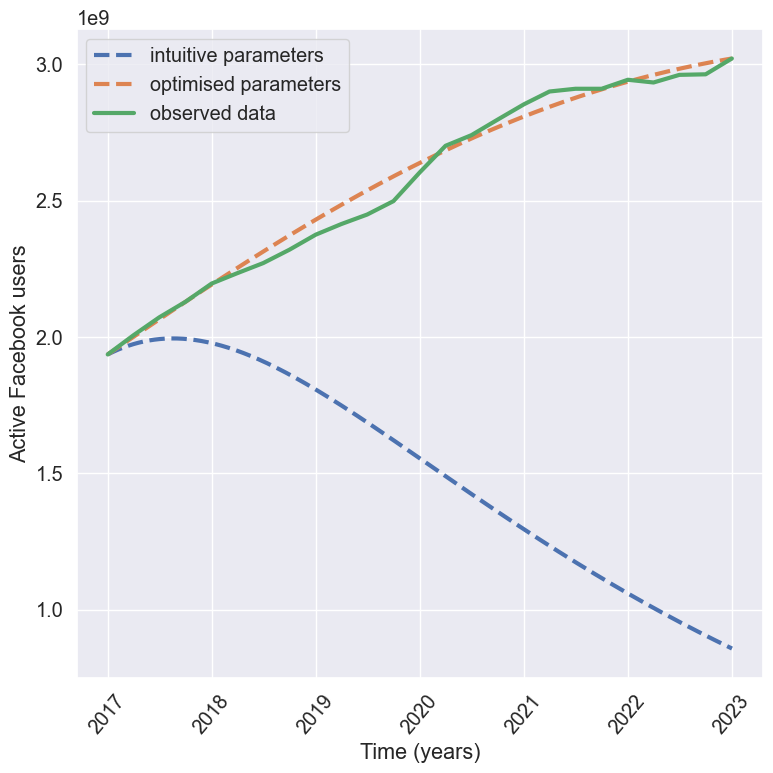

In [44]:
FIGURE_WIDTH = 8
FIGURE_HEIGHT = 8
LINEWIDTH = 3
FONT_SCALE = 1.3

MODEL_LINESTYLE = 'dashed'
OBSERVED_LINESTYLE = 'solid'

sns.set_theme()
sns.set(font_scale=FONT_SCALE)
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.lineplot(data=model_intuitive, x='timestamp_milliseconds', y='I', label='intuitive parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
sns.lineplot(data=model_optimized, x='timestamp_milliseconds', y='I', label='optimised parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
sns.lineplot(data=observed, x='timestamp_milliseconds', y='MAU', label='observed data', linewidth=LINEWIDTH, linestyle=OBSERVED_LINESTYLE)

def timestamp_milliseconds_to_year(timestamp_milliseconds: float) -> int:
    date = milliseconds_to_date(timestamp_milliseconds)
    return date.year

def year_to_timestamp_milliseconds(year: int) -> float:
    date = dt.datetime(year, 1, 1)
    return date_to_milliseconds(date)

all_timestamps_milliseconds = np.concatenate([
    model_intuitive['timestamp_milliseconds'], 
    model_optimized['timestamp_milliseconds'], 
    observed['timestamp_milliseconds'],
])
min_year = timestamp_milliseconds_to_year(np.min(all_timestamps_milliseconds))
max_year = timestamp_milliseconds_to_year(np.max(all_timestamps_milliseconds))
years = np.arange(min_year, max_year + 1) # FIXME: CHECK OF 2017 - 2023 IS
xticks = list(map(year_to_timestamp_milliseconds, years)) # FIXME: CHECK OF WEGHALEN LIST NIET ERG IS
xlabels = years

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)

plt.xlabel('Time (years)')
plt.ylabel('Active Facebook users')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'basic_facebook_sir_model_parameter_optimization.svg')
plt.show()